# TP1 - Menceyra - Viaggio

### Pipeline: 
(1) Deteccion y descripcion de Caracteristicas visuales(features)

(2) Supresion no Maxima Adaptativa

(3) Asociacion de caracteristicas(Matching)

(4) Asociacion de correspondencias

(5) Eliminacion de outliers utilizando RANSAC

(6) Estimacion de la homografia

(7) Juntar y mezclar imagenes

### (1) Etapa 1 - Deteccion de Caracteristicas - 

[cuadro_0.jpg] keypoints=763 | desc_shape=(763, 128)
[cuadro_1.jpg] keypoints=617 | desc_shape=(617, 128)  <- ANCLA
[cuadro_2.jpg] keypoints=750 | desc_shape=(750, 128)


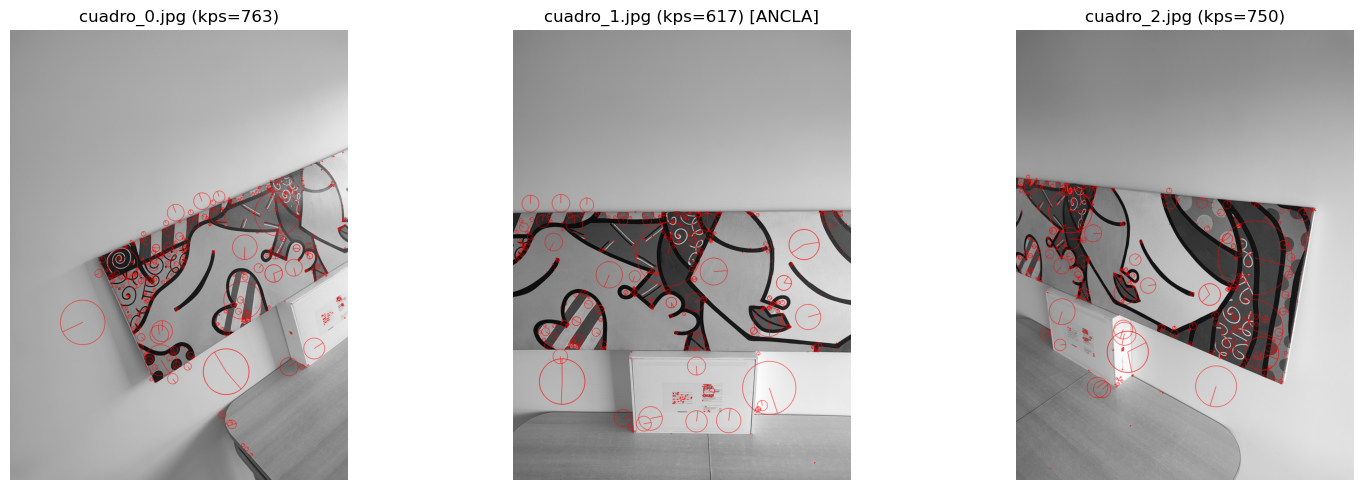

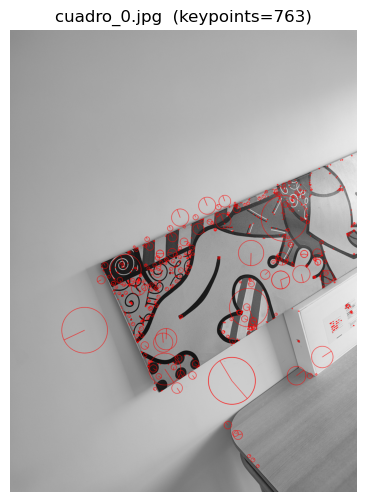

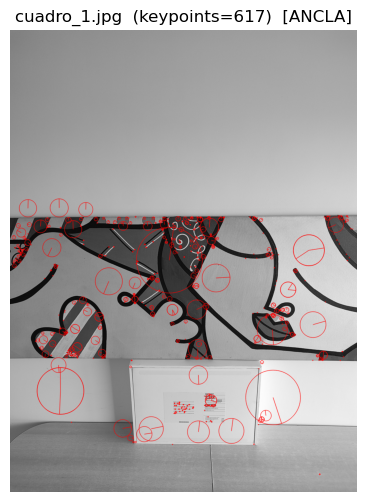

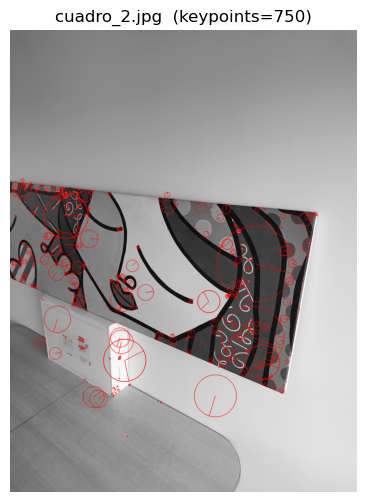

In [2]:
# === Etapa 1: Detección y descripción de características (SIFT) ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Config simple ---
IMG_DIR = Path("img")                 # carpeta 
SET = "cuadro"                         # prefijo de las imágenes a usar
FILES = [f"{SET}_0.jpg", f"{SET}_1.jpg", f"{SET}_2.jpg"]
ANCHOR_IDX = 1                        # tomo la del medio como "ancla"
RESIZE_W = 1000                       # ancho target (None = tamaño original)

def imread_rgb(path: Path):
    """Leo con cv2 y devuelvo en RGB (para mostrar con plt)."""
    bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    assert bgr is not None, f"No pude leer {path}"
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def resize_w(img, w):
    """Redimensiono manteniendo aspecto (suave para trabajar cómodo)."""
    if w is None or img.shape[1] <= w:
        return img
    r = w / img.shape[1]
    return cv2.resize(img, (int(img.shape[1]*r), int(img.shape[0]*r)), interpolation=cv2.INTER_AREA)

# --- Cargo + preparo (RGB para mostrar luego, GRAY para SIFT) ---
imgs_rgb, imgs_gray = [], []
for f in FILES:
    rgb = imread_rgb(IMG_DIR / f)
    rgb = resize_w(rgb, RESIZE_W)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    imgs_rgb.append(rgb)
    imgs_gray.append(gray)

# --- SIFT (si falla, instalar opencv-contrib-python) ---
sift = cv2.SIFT_create()

kps_list, desc_list = [], []
for gray in imgs_gray:
    kps, desc = sift.detectAndCompute(gray, None)
    kps_list.append(kps)
    desc_list.append(desc)

# --- Info rápida para entender qué tenemos ---
for i, f in enumerate(FILES):
    shp = None if desc_list[i] is None else desc_list[i].shape
    print(f"[{f}] keypoints={len(kps_list[i])} | desc_shape={shp}" + ("  <- ANCLA" if i==ANCHOR_IDX else ""))

# === Visualización de keypoints ===
# Usamos la imagen en escala de grises como base para que los puntos se vean claros

# --- Lado a lado (overview rápido) ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i, ax in enumerate(axes):
    vis = cv2.drawKeypoints(
        imgs_gray[i], kps_list[i], None,
        color=(255,0,0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    ax.imshow(vis, cmap="gray")
    ax.set_title(f"{FILES[i]} (kps={len(kps_list[i])})" + (" [ANCLA]" if i==ANCHOR_IDX else ""))
    ax.axis("off")
plt.tight_layout()
plt.show()

# --- Cada una individual (zoom para ver detalles) ---
for i in range(3):
    vis = cv2.drawKeypoints(
        imgs_gray[i], kps_list[i], None,
        color=(255,0,0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    plt.figure(figsize=(8,6))
    plt.imshow(vis, cmap="gray")
    plt.title(f"{FILES[i]}  (keypoints={len(kps_list[i])})" + ("  [ANCLA]" if i==ANCHOR_IDX else ""))
    plt.axis("off")
    plt.show()

# --- Dejamos todo listo para el Paso 2 (ANMS) y los siguientes ---
pano_data = {
    "files": FILES,
    "imgs_rgb": imgs_rgb,
    "imgs_gray": imgs_gray,
    "kps": kps_list,
    "desc": desc_list,
    "anchor_idx": ANCHOR_IDX
}


### (2) Etapa 2 - Supresion no maxima adaptativa - 

cuadro_0.jpg: antes= 763  después(ANMS)= 763
cuadro_1.jpg: antes= 617  después(ANMS)= 617
cuadro_2.jpg: antes= 750  después(ANMS)= 750


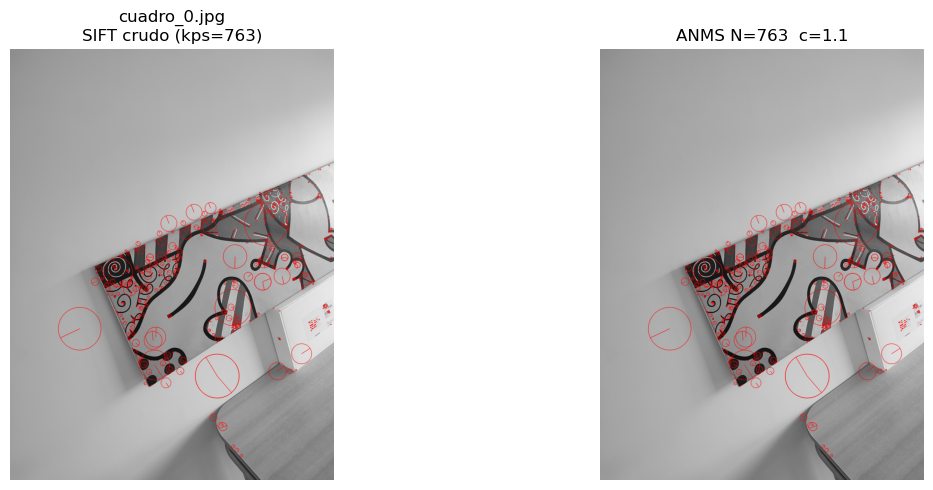

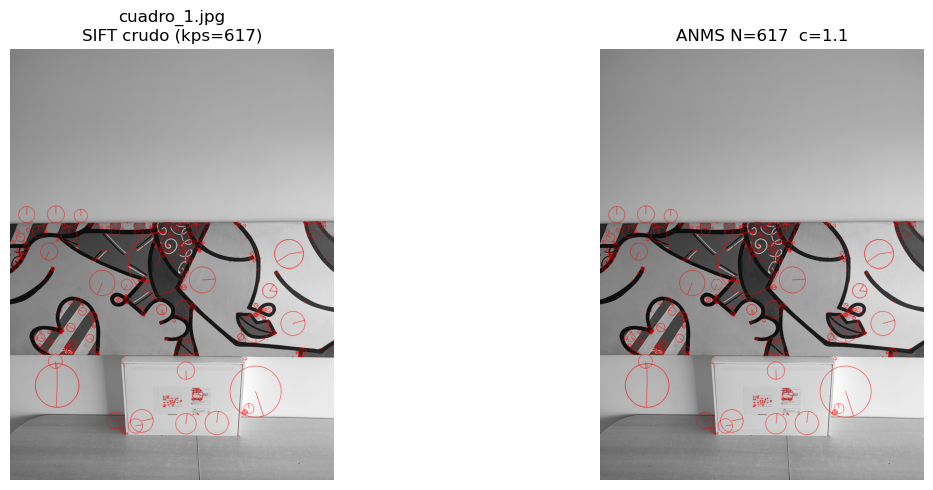

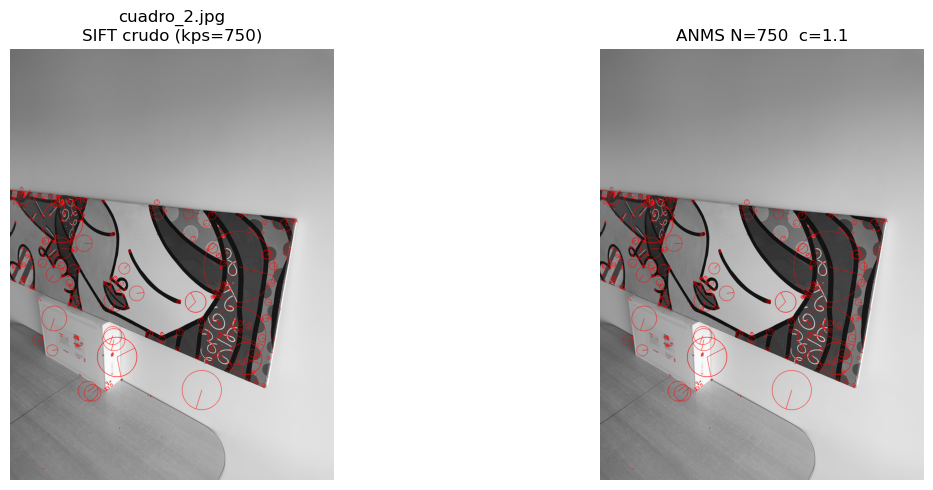

OK: ANMS listo. Pasamos a matching usando solo (kps_anms, desc_anms).


In [3]:
# === Etapa 2: ANMS (Adaptive Non-Maximal Suppression) ===
# Objetivo: quedarnos con N puntos fuertes y bien distribuidos (evita amontonamientos)

import numpy as np
import matplotlib.pyplot as plt
import cv2

def anms_select(keypoints, descriptors, N=800, c_robust=1.1):
    """
    ANMS clásico:
    - Para cada punto i, busco la distancia mínima a cualquier punto j "signif. más fuerte"
      (response_j >= c_robust * response_i).
    - Ese mínimo es el radio de supresión r_i.
    - Me quedo con los N de mayor r_i (fuertes + aislados).
    """
    n = len(keypoints)
    if n == 0:
        return [], None

    # coords (x, y) y fuerza (response) de cada kp
    pts = np.array([kp.pt for kp in keypoints], dtype=np.float32)     # (n, 2)
    resp = np.array([kp.response for kp in keypoints], dtype=np.float32)

    # ordeno por fuerza (desc) → “antes” de i son más fuertes
    order = np.argsort(-resp)
    radii = np.full(n, np.inf, dtype=np.float32)  # r_i

    # recorro de fuerte → débil y calculo radio contra puntos "suficientemente" más fuertes
    for rank, idx in enumerate(order):
        if rank == 0:
            continue  # el más fuerte queda con radio infinito
        stronger = order[:rank]
        mask = resp[stronger] >= c_robust * resp[idx]
        if not np.any(mask):
            continue
        cand = stronger[mask]
        d2 = np.sum((pts[cand] - pts[idx])**2, axis=1)
        radii[idx] = np.sqrt(d2.min())

    # selecciono los N con mayor radio
    N_eff = min(N, n)
    keep_idx = np.argsort(-radii)[:N_eff]

    kps_sel = [keypoints[i] for i in keep_idx]
    desc_sel = None if descriptors is None else descriptors[keep_idx]
    return kps_sel, desc_sel

# --- Aplicamos ANMS a cada imagen del set ---
N_TARGET = 800
C_ROBUST = 1.1

kps_anms_list, desc_anms_list = [], []
for i in range(3):
    kps = pano_data["kps"][i]
    desc = pano_data["desc"][i]
    kps_anms, desc_anms = anms_select(kps, desc, N=N_TARGET, c_robust=C_ROBUST)
    kps_anms_list.append(kps_anms)
    desc_anms_list.append(desc_anms)
    print(f"{pano_data['files'][i]}: antes={len(kps):4d}  después(ANMS)={len(kps_anms):4d}")

# guardo en el “paquete” para el siguiente paso
pano_data["kps_anms"] = kps_anms_list
pano_data["desc_anms"] = desc_anms_list
pano_data["anms_params"] = {"N": N_TARGET, "c_robust": C_ROBUST}

# --- Visualización: antes vs. después (por imagen, en gris) ---
for i in range(3):
    gray = pano_data["imgs_gray"][i]
    kps_all = pano_data["kps"][i]
    kps_sel = pano_data["kps_anms"][i]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    vis_all = cv2.drawKeypoints(gray, kps_all, None,
                                color=(255,0,0),
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    vis_sel = cv2.drawKeypoints(gray, kps_sel, None,
                                color=(255,0,0),
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    axes[0].imshow(vis_all, cmap="gray")
    axes[0].set_title(f"{pano_data['files'][i]}\nSIFT crudo (kps={len(kps_all)})")
    axes[0].axis("off")

    axes[1].imshow(vis_sel, cmap="gray")
    axes[1].set_title(f"ANMS N={len(kps_sel)}  c={C_ROBUST}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

print("OK: ANMS listo. Pasamos a matching usando solo (kps_anms, desc_anms).")


### (3) Etapa 3 - Asociacion de caracteristicas (Matching) - 

cuadro_1.jpg ↔ cuadro_0.jpg: matches ratio= 165  


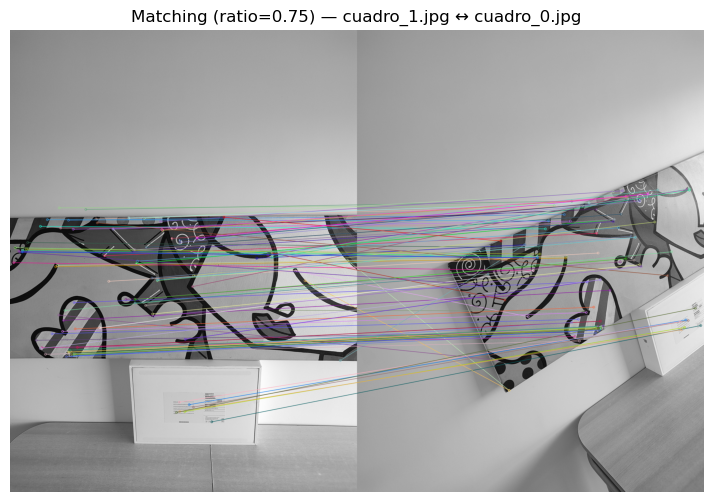

cuadro_1.jpg ↔ cuadro_2.jpg: matches ratio=  93  


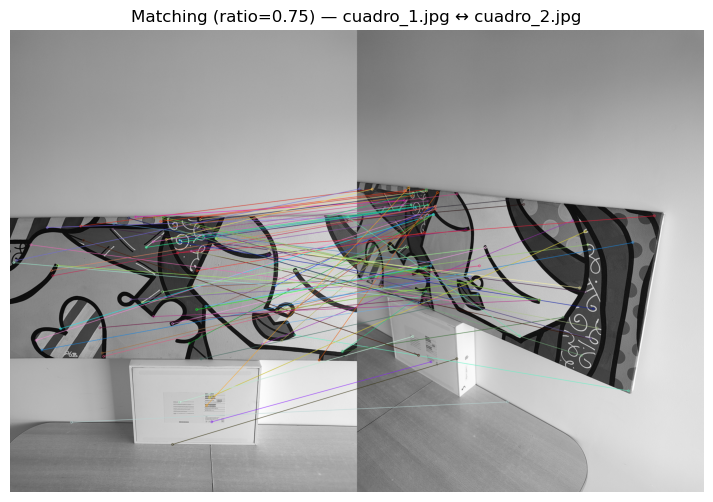

OK: Matching listo. Usá pano_data['matches'][<par>]['ptsA'/'ptsB'] para DLT/RANSAC.


In [4]:
# === Etapa 3.3: Asociación de características (Matching) ===
# Idea: usar descriptores SIFT (filtrados por ANMS) para emparejar puntos entre imágenes.
# Herramientas: BFMatcher + knnMatch(k=2), Lowe ratio test, opcional cross-check.

import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import sample

# --- helpers ---

def _ensure_anms(pano_data):
    """Si no corriste ANMS aún, usa SIFT crudo. Caso normal: usa kps/desc de ANMS."""
    if "kps_anms" in pano_data and "desc_anms" in pano_data:
        return pano_data["kps_anms"], pano_data["desc_anms"]
    return pano_data["kps"], pano_data["desc"]

def lowe_ratio_filter(knn_matches, ratio=0.75):
    """Aplico ratio test: me quedo con m si dist(m) < ratio * dist(n)."""
    good = []
    for m, n in knn_matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

def cross_check_filter(matches_ab, matches_ba):
    """
    Cross-check simétrico:
    - matches_ab: mejores matches A->B (lista de DMatch con queryIdx en A, trainIdx en B)
    - matches_ba: mejores matches B->A
    Me quedo solo con parejas que sean recíprocas.
    """
    map_ab = {(m.queryIdx, m.trainIdx) for m in matches_ab}
    map_ba = {(m.trainIdx, m.queryIdx) for m in matches_ba}
    inter = map_ab & map_ba  # pares recíprocos
    return [cv2.DMatch(_queryIdx=i, _trainIdx=j, _imgIdx=0, _distance=0) for (i, j) in inter]

def extract_matched_points(kpsA, kpsB, matches):
    """De DMatch -> arrays Nx2 de coordenadas (x,y) en cada imagen."""
    ptsA = np.float32([kpsA[m.queryIdx].pt for m in matches])
    ptsB = np.float32([kpsB[m.trainIdx].pt for m in matches])
    return ptsA, ptsB

def draw_matches_gray(grayA, grayB, kpsA, kpsB, matches, max_draw=80, title=""):
    """
    Visualizo matches sobre fondo gris (estilo clase).
    - Submuestreo para no saturar la figura (max_draw).
    """
    if len(matches) > max_draw:
        matches = [matches[i] for i in sorted(sample(range(len(matches)), max_draw))]
    # drawMatches espera BGR de 3 canales
    A_bgr = cv2.cvtColor(grayA, cv2.COLOR_GRAY2BGR)
    B_bgr = cv2.cvtColor(grayB, cv2.COLOR_GRAY2BGR)
    vis = cv2.drawMatches(A_bgr, kpsA, B_bgr, kpsB, matches, None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(14, 6))
    # Mostrar en RGB para matplotlib
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# --- matching principal (ancla vs vecinos) ---

# Tomo los keypoints/desc filtrados
kps_list, desc_list = _ensure_anms(pano_data)

anchor = pano_data["anchor_idx"]
pairs = []
if anchor - 1 >= 0: pairs.append((anchor, anchor - 1))   # ancla ↔ izquierda
if anchor + 1 < len(kps_list): pairs.append((anchor, anchor + 1))  # ancla ↔ derecha

# Parámetros típicos
RATIO = 0.75        # Lowe ratio
DO_CROSSCHECK = False  # podés probar True para combinar políticas

matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)  # SIFT -> NORM_L2

match_results = {}  # guardo todo para homografía
for iA, iB in pairs:
    descA, descB = desc_list[iA], desc_list[iB]
    kpsA,  kpsB  = kps_list[iA], kps_list[iB]

    # knn (2 vecinos) en ambos sentidos
    knnAB = matcher.knnMatch(descA, descB, k=2)
    knnBA = matcher.knnMatch(descB, descA, k=2)

    # Lowe ratio
    goodAB = lowe_ratio_filter(knnAB, ratio=RATIO)
    goodBA = lowe_ratio_filter(knnBA, ratio=RATIO)

    # Opcional: cross-check simétrico sobre los good
    if DO_CROSSCHECK:
        good = cross_check_filter(goodAB, goodBA)
    else:
        good = goodAB

    # Extraigo puntos emparejados
    ptsA, ptsB = extract_matched_points(kpsA, kpsB, good)

    # Guardo para próximos pasos
    key = f"{pano_data['files'][iA]} ↔ {pano_data['files'][iB]}"
    match_results[key] = {
        "iA": iA, "iB": iB,
        "matches": good,
        "ptsA": ptsA, "ptsB": ptsB,
        "kpsA": kpsA, "kpsB": kpsB
    }

    # Logs rápidos
    print(f"{key}: matches ratio={len(goodAB):4d}  "
          + (f"(ratio+cross={len(good):4d})" if DO_CROSSCHECK else ""))

    # Visualización (gris, con submuestreo para claridad)
    draw_matches_gray(
        pano_data["imgs_gray"][iA],
        pano_data["imgs_gray"][iB],
        kpsA, kpsB, good,
        max_draw=100,
        title=f"Matching (ratio={RATIO}" + (", cross-check" if DO_CROSSCHECK else "") + f") — {key}"
    )

# Empaqueto resultados para homografía (paso 4/5)
pano_data["matches"] = match_results
pano_data["matching_params"] = {"ratio": RATIO, "cross_check": DO_CROSSCHECK}

print("OK: Matching listo. Usá pano_data['matches'][<par>]['ptsA'/'ptsB'] para DLT/RANSAC.")


=== Política A: SOLO Lowe ratio ===
cuadro_1.jpg ↔ cuadro_0.jpg: matches (ratio=0.75) = 165


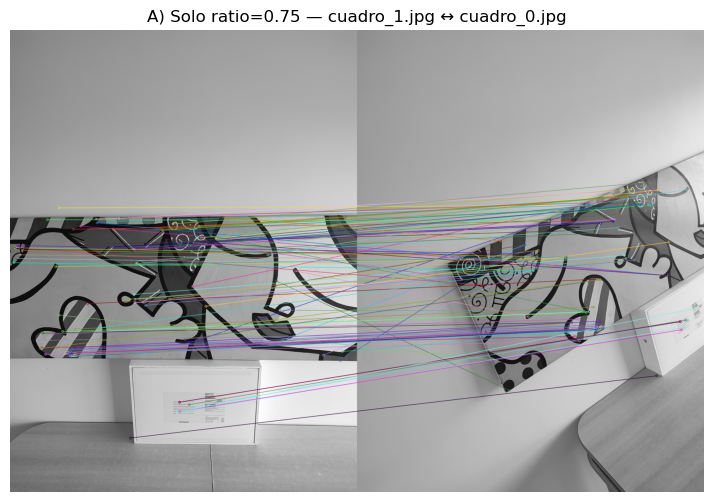

cuadro_1.jpg ↔ cuadro_2.jpg: matches (ratio=0.75) = 93


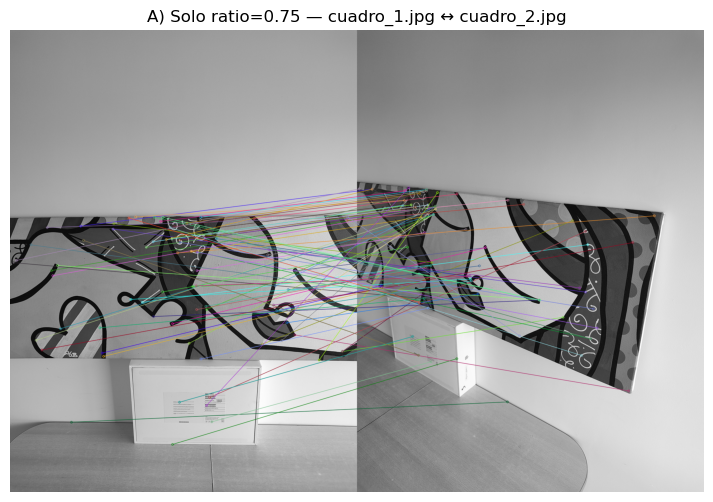


=== Política B: Lowe ratio + Cross-check ===
cuadro_1.jpg ↔ cuadro_0.jpg: matches (ratio+cross) = 115  |  solo ratio tenía 165


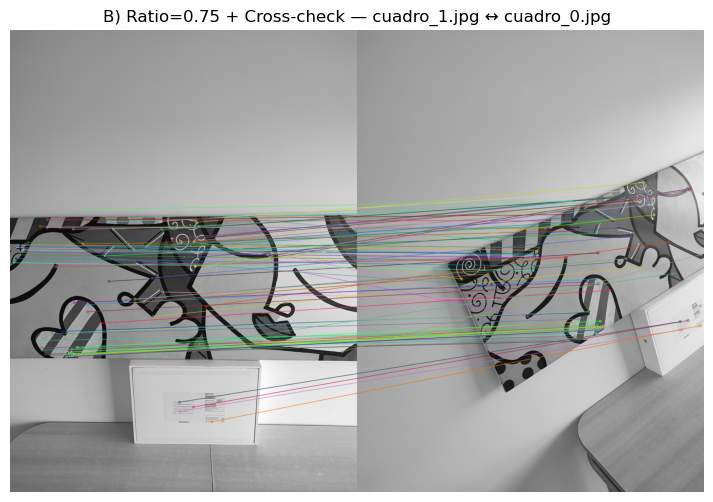

cuadro_1.jpg ↔ cuadro_2.jpg: matches (ratio+cross) = 48  |  solo ratio tenía 93


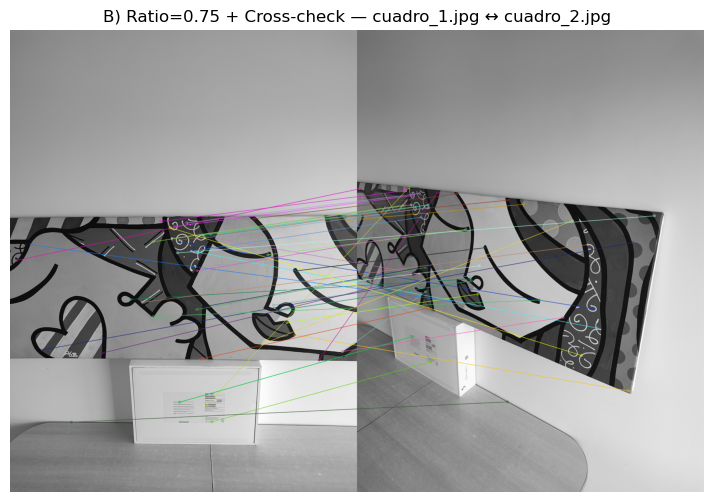


Listo: tenés ambos sets en pano_data['matches_ratio'] y ['matches_ratio_xcheck'] para DLT/RANSAC.


In [5]:
# === Etapa 3.3 (mini): comparación de políticas de matching ===
import cv2, numpy as np, matplotlib.pyplot as plt
from random import sample

def lowe_ratio_filter(knn_matches, ratio=0.75):
    good = []
    for m, n in knn_matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

def cross_check_filter(matches_ab, matches_ba):
    AB = {(m.queryIdx, m.trainIdx) for m in matches_ab}
    BA = {(m.trainIdx, m.queryIdx) for m in matches_ba}
    inter = AB & BA
    # reconstruyo DMatch para dibujar/llevar a pts
    return [cv2.DMatch(_queryIdx=i, _trainIdx=j, _imgIdx=0, _distance=0) for (i, j) in inter]

def extract_pts(kpsA, kpsB, matches):
    ptsA = np.float32([kpsA[m.queryIdx].pt for m in matches])
    ptsB = np.float32([kpsB[m.trainIdx].pt for m in matches])
    return ptsA, ptsB

def draw_matches_gray(grayA, grayB, kpsA, kpsB, matches, title, max_draw=80):
    if len(matches) > max_draw:
        idxs = sorted(sample(range(len(matches)), max_draw))
        matches = [matches[i] for i in idxs]
    A = cv2.cvtColor(grayA, cv2.COLOR_GRAY2BGR)
    B = cv2.cvtColor(grayB, cv2.COLOR_GRAY2BGR)
    vis = cv2.drawMatches(A, kpsA, B, kpsB, matches, None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(14,6))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis("off"); plt.show()

# --- Datos (usamos ANMS si está; si no, SIFT crudo) ---
kps_list = pano_data.get("kps_anms", pano_data["kps"])
desc_list = pano_data.get("desc_anms", pano_data["desc"])
anchor = pano_data["anchor_idx"]

pairs = []
if anchor - 1 >= 0: pairs.append((anchor, anchor-1))
if anchor + 1 < len(kps_list): pairs.append((anchor, anchor+1))

# --- Parámetros ---
RATIO = 0.75
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)  # SIFT -> L2

# --- A) SOLO RATIO ---
matches_ratio = {}
print("=== Política A: SOLO Lowe ratio ===")
for iA, iB in pairs:
    kpsA, kpsB = kps_list[iA], kps_list[iB]
    descA, descB = desc_list[iA], desc_list[iB]

    knnAB = matcher.knnMatch(descA, descB, k=2)
    goodAB = lowe_ratio_filter(knnAB, ratio=RATIO)

    ptsA, ptsB = extract_pts(kpsA, kpsB, goodAB)
    key = f"{pano_data['files'][iA]} ↔ {pano_data['files'][iB]}"
    matches_ratio[key] = {"matches": goodAB, "ptsA": ptsA, "ptsB": ptsB, "iA": iA, "iB": iB}

    print(f"{key}: matches (ratio={RATIO}) = {len(goodAB)}")
    draw_matches_gray(pano_data["imgs_gray"][iA], pano_data["imgs_gray"][iB],
                      kpsA, kpsB, goodAB, title=f"A) Solo ratio={RATIO} — {key}", max_draw=100)

pano_data["matches_ratio"] = matches_ratio

# --- B) RATIO + CROSS-CHECK ---
matches_ratio_xc = {}
print("\n=== Política B: Lowe ratio + Cross-check ===")
for iA, iB in pairs:
    kpsA, kpsB = kps_list[iA], kps_list[iB]
    descA, descB = desc_list[iA], desc_list[iB]

    knnAB = matcher.knnMatch(descA, descB, k=2)
    knnBA = matcher.knnMatch(descB, descA, k=2)

    goodAB = lowe_ratio_filter(knnAB, ratio=RATIO)
    goodBA = lowe_ratio_filter(knnBA, ratio=RATIO)
    both = cross_check_filter(goodAB, goodBA)

    ptsA, ptsB = extract_pts(kpsA, kpsB, both)
    key = f"{pano_data['files'][iA]} ↔ {pano_data['files'][iB]}"
    matches_ratio_xc[key] = {"matches": both, "ptsA": ptsA, "ptsB": ptsB, "iA": iA, "iB": iB}

    print(f"{key}: matches (ratio+cross) = {len(both)}  |  solo ratio tenía {len(goodAB)}")
    draw_matches_gray(pano_data["imgs_gray"][iA], pano_data["imgs_gray"][iB],
                      kpsA, kpsB, both, title=f"B) Ratio={RATIO} + Cross-check — {key}", max_draw=100)

pano_data["matches_ratio_xcheck"] = matches_ratio_xc

print("\nListo: tenés ambos sets en pano_data['matches_ratio'] y ['matches_ratio_xcheck'] para DLT/RANSAC.")


### (4) Etapa 4 - Estimacion de la Homografia 'manualmente' - 

In [6]:
# === Etapa 4: Estimación de homografía (DLT) ===


Par 0

In [7]:
# === Elegí el par que querés usar para DLT, tal como aparece en tu celda de matching ===
pairs = list(pano_data["matches"].keys())
for p in pairs:
    print("par:", p)

# Tomamos, por ejemplo, el primero (cambialo si querés el otro)
par0 = pairs[0]   # p.ej. "udesa_1.jpg ↔ udesa_0.jpg"
info0 = pano_data["matches"][par0]
iA0, iB0 = info0["iA"], info0["iB"]

# Recupero las imágenes en RGB (las mismas que graficaste)
imgA0 = pano_data["imgs_rgb"][iA0]  # ancla
imgB0 = pano_data["imgs_rgb"][iB0]  # vecina

print("A:", pano_data["files"][iA0], " |  B:", pano_data["files"][iB0])

par: cuadro_1.jpg ↔ cuadro_0.jpg
par: cuadro_1.jpg ↔ cuadro_2.jpg
A: cuadro_1.jpg  |  B: cuadro_0.jpg


In [8]:
import cv2
import numpy as np

ori_pts:
 [[611 541]
 [415 715]
 [737 805]
 [700 918]]
dst_pts:
 [[864 414]
 [793 597]
 [986 569]
 [988 659]]
Homografía (DLT):
 [[ 5.85205017e-01  2.93005625e-01  3.91086851e+02]
 [-3.02053482e-01  8.10877978e-01  1.80552039e+02]
 [ 6.14223089e-06  8.54056522e-05  1.00000000e+00]]


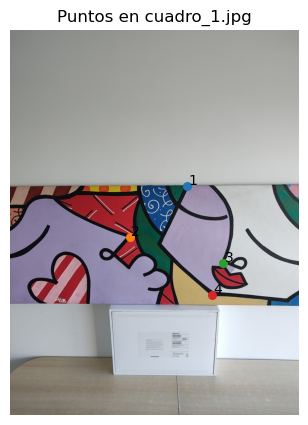

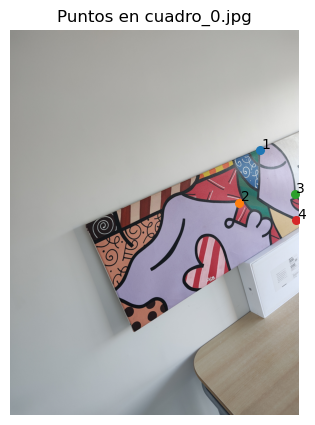

In [9]:
from utils import pick_points, dlt, show_points  # tu implementación

# 1) Elegí 4 puntos en A y los mismos 4 en B (mantené el orden!)
ori_pts0 = pick_points(imgA0, n=4, win_name=f"Puntos en {pano_data['files'][iA0]}")
dst_pts0 = pick_points(imgB0, n=4, win_name=f"Puntos en {pano_data['files'][iB0]}")

print("ori_pts:\n", ori_pts0)
print("dst_pts:\n", dst_pts0)

# 2) Homografía por DLT
H0 = dlt(ori_pts0, dst_pts0)
print("Homografía (DLT):\n", H0)

# 3) (opcional) dibujar los puntos numerados para chequear el orden
show_points(imgA0, ori_pts0, f"Puntos en {pano_data['files'][iA0]}")
show_points(imgB0, dst_pts0, f"Puntos en {pano_data['files'][iB0]}")

In [10]:
H_cv0, _ = cv2.findHomography(ori_pts0, dst_pts0, method=0)  # 0 = DLT puro

In [11]:
# def normH(H):
#     H = H / H[2,2] if abs(H[2,2]) > 1e-12 else H / np.linalg.norm(H)
#     if H[2,2] < 0: H = -H
#     return H

# H1 = normH(H)   # tu DLT
# H2 = normH(H_cv)    # OpenCV sin RANSAC
# print("||H1 - H2||_F =", np.linalg.norm(H1 - H2, 'fro'))

In [12]:
# def proj(H, P):
#     P1 = np.hstack([P, np.ones((P.shape[0],1))])
#     Q  = (H @ P1.T).T
#     return Q[:, :2] / Q[:, 2:3]

# def err_sym(H, A, B):
#     e1 = np.linalg.norm(proj(H, A) - B, axis=1)
#     e2 = np.linalg.norm(proj(np.linalg.inv(H), B) - A, axis=1)
#     return e1 + e2

# e_dlt = err_sym(H, ori_pts, dst_pts)
# e_cv  = err_sym(H_cv,  ori_pts, dst_pts)
# print("RMS DLT:", np.sqrt((e_dlt**2).mean()), "px")
# print("RMS CV :", np.sqrt((e_cv**2).mean()),  "px")

In [13]:
print(H0)
print(H_cv0)

[[ 5.85205017e-01  2.93005625e-01  3.91086851e+02]
 [-3.02053482e-01  8.10877978e-01  1.80552039e+02]
 [ 6.14223089e-06  8.54056522e-05  1.00000000e+00]]
[[ 5.85205017e-01  2.93005625e-01  3.91086851e+02]
 [-3.02053482e-01  8.10877978e-01  1.80552039e+02]
 [ 6.14223089e-06  8.54056522e-05  1.00000000e+00]]


Par 1

In [14]:
# Tomamos, por ejemplo, el primero (cambialo si querés el otro)
par1 = pairs[1]   # p.ej. "udesa_1.jpg ↔ udesa_0.jpg"
info1 = pano_data["matches"][par1]
iA1, iB1 = info1["iA"], info1["iB"]

# Recupero las imágenes en RGB (las mismas que graficaste)
imgA1 = pano_data["imgs_rgb"][iA1]  # ancla
imgB1 = pano_data["imgs_rgb"][iB1]  # vecina

print("A:", pano_data["files"][iA1], " |  B:", pano_data["files"][iB1])

A: cuadro_1.jpg  |  B: cuadro_2.jpg


In [15]:
# 1) Elegí 4 puntos en A y los mismos 4 en B (mantené el orden!)
ori_pts1 = pick_points_cv2(imgA1, n=4, win_name=f"Puntos en {pano_data['files'][iA1]}")
dst_pts1 = pick_points_cv2(imgB1, n=4, win_name=f"Puntos en {pano_data['files'][iB1]}")

print("ori_pts:\n", ori_pts1)
print("dst_pts:\n", dst_pts1)

# 2) Homografía por DLT
H1 = dlt(ori_pts1, dst_pts1)
print("Homografía (DLT):\n", H1)

show_points(imgA1, ori_pts1, f"Puntos en {pano_data['files'][iA1]}")
show_points(imgB1, dst_pts1, f"Puntos en {pano_data['files'][iB1]}")

NameError: name 'pick_points_cv2' is not defined

In [ ]:
H_cv1, _ = cv2.findHomography(ori_pts1, dst_pts1, method=0)  # 0 = DLT puro

print(H1)
print(H_cv1)

[[ 7.66739071e-01  1.26038161e-01 -2.46105080e+02]
 [ 1.94404069e-01  1.44729028e+00 -3.28728648e+02]
 [ 1.39982944e-07  4.57756455e-04  1.00000000e+00]]
[[ 7.66739071e-01  1.26038161e-01 -2.46105080e+02]
 [ 1.94404069e-01  1.44729028e+00 -3.28728648e+02]
 [ 1.39982944e-07  4.57756455e-04  1.00000000e+00]]


### (5) Etapa 5 - RANSAC para eliminacion de outliers y estimacion de homografias - 

In [16]:
# === RANSAC (A <- B) ===
def _proj(H, P):
    """Proyecta P (N,2) con H, devuelve (N,2)."""
    P1 = np.hstack([P, np.ones((P.shape[0], 1))])
    Q  = (H @ P1.T).T
    return Q[:, :2] / Q[:, 2:3]

def _sym_reproj_error(H, A, B):
    """
    Error simétrico COHERENTE con H: A <- B
    forward:  B --H--> Â  y comparamos con A
    backward: A --H⁻¹--> B̂ y comparamos con B
    """
    # Si H es singular/condición mala, devolvemos inf para forzar descarte
    if np.linalg.cond(H) > 1e12:
        return np.full(A.shape[0], np.inf)

    # forward B->A
    A_hat = _proj(H, B)
    e_fwd = np.linalg.norm(A_hat - A, axis=1)

    # backward A->B
    try:
        Hinv = np.linalg.inv(H)
    except np.linalg.LinAlgError:
        return np.full(A.shape[0], np.inf)
    B_hat = _proj(Hinv, A)
    e_bwd = np.linalg.norm(B_hat - B, axis=1)

    return e_fwd + e_bwd

def _degenerate(pts):
    """Evitar 4 puntos casi colineales (área ~ 0)."""
    x, y = pts[:,0], pts[:,1]
    area = 0.5 * abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))
    return area < 1e-3

def ransac_homography(ptsA, ptsB, thresh=3.0, max_trials=2000, confidence=0.995, random_state=None):
    """
    Estima H robusta con RANSAC + refinamiento final con inliers.
    H es A <- B (warp B sobre A).
    - ptsA, ptsB: arrays (N,2) en correspondencia (float).
    - thresh: umbral de inlier en píxeles para error simétrico.
    """
    A = np.asarray(ptsA, dtype=float)
    B = np.asarray(ptsB, dtype=float)
    assert A.shape == B.shape and A.shape[0] >= 4
    N = A.shape[0]
    rng = np.random.default_rng(random_state)

    best_H = None
    best_inliers = None
    best_n = 0

    s = 4  # tamaño de muestra mínima
    T = max_trials

    for t in range(T):
        idx = rng.choice(N, size=s, replace=False)
        if _degenerate(A[idx]) or _degenerate(B[idx]):
            continue

        # *** CORRECCIÓN CLAVE: H = A <- B ***
        try:
            H = dlt(B[idx], A[idx])   # origen: B; destino: A
        except np.linalg.LinAlgError:
            continue

        # Si H es mal condicionada, saltamos hipótesis
        if not np.all(np.isfinite(H)) or np.linalg.cond(H) > 1e12:
            continue

        err = _sym_reproj_error(H, A, B)
        inliers = err < thresh
        ninl = int(inliers.sum())

        if ninl > best_n:
            best_n = ninl
            best_inliers = inliers
            best_H = H

            # actualización adaptativa del número de iteraciones
            w = ninl / N
            w = min(max(w, 1e-6), 1 - 1e-6)
            need = np.log(1 - confidence) / np.log(1 - w**s)
            T = int(min(T, max(100, np.ceil(need))))

    if best_inliers is None or best_n < 4:
        raise RuntimeError("RANSAC no encontró modelo. Ajustá 'thresh' o revisá los datos.")

    # Refinar con TODOS los inliers (SIN RANSAC), como pide la consigna:
    A_in = A[best_inliers]
    B_in = B[best_inliers]

    # Opción A (tu DLT):
    # H_ref = dlt(B_in, A_in)

    # Opción B (permitida por consigna, SIN RANSAC):  (si querés comparar, descomentá)
    H_ref, _ = cv2.findHomography(B_in, A_in, method=0)

    return H_ref, best_inliers

# --- Ejecución con pano_data ---
pairs = list(pano_data["matches"].keys())
par = pairs[0]  # elegí el par que quieras
m = pano_data["matches"][par]

# IMPORTANTE: asegurate que m["ptsA"] sean puntos en ANCLA (A)
# y m["ptsB"] en la OTRA imagen (B)
ptsA = np.array(m["ptsA"], dtype=float)
ptsB = np.array(m["ptsB"], dtype=float)

H_ransac, inliers_mask = ransac_homography(ptsA, ptsB, thresh=3.5, max_trials=3000, confidence=0.995, random_state=42)
print("Inliers:", int(inliers_mask.sum()), "/", len(inliers_mask))
print("H (RANSAC + refino sin RANSAC):\n", H_ransac)

# Comparación opcional con OpenCV usando RANSAC (SOLO para chequeo, no para la entrega)
H_cv, mask_cv = cv2.findHomography(ptsB, ptsA, method=cv2.RANSAC, ransacReprojThreshold=3.5, maxIters=3000, confidence=0.995)
print("Inliers cv2:", int(mask_cv.sum()), "/", len(mask_cv))

def rms(x): return np.sqrt((x**2).mean())
e_ours = _sym_reproj_error(H_ransac, ptsA, ptsB)
e_cv   = _sym_reproj_error(H_cv,     ptsA, ptsB)
print("RMS our H (inliers):", rms(e_ours[inliers_mask]))
print("RMS cv2 H (inliers):", rms(e_cv[mask_cv.ravel().astype(bool)]))


Inliers: 72 / 165
H (RANSAC + refino sin RANSAC):
 [[ 1.05901059e+00 -2.85512414e-01 -3.30340607e+02]
 [ 2.07695001e-01  1.04503749e+00 -1.97366412e+02]
 [-3.59233700e-04  1.81012575e-04  1.00000000e+00]]
Inliers cv2: 84 / 165
RMS our H (inliers): 1.9505701471093613
RMS cv2 H (inliers): 2.445103510149995


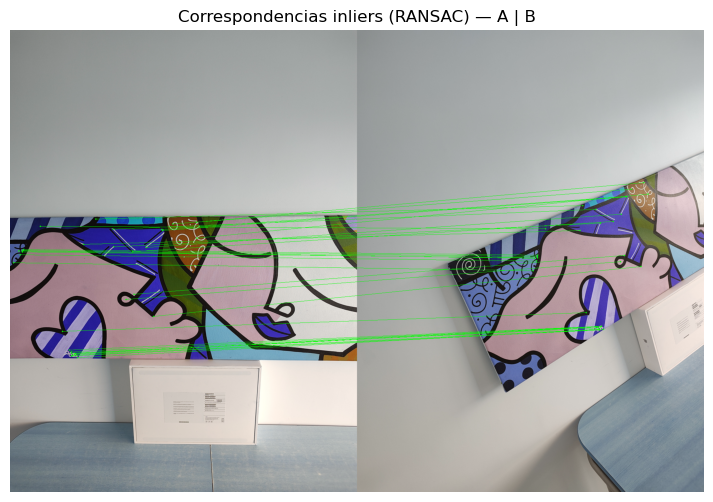

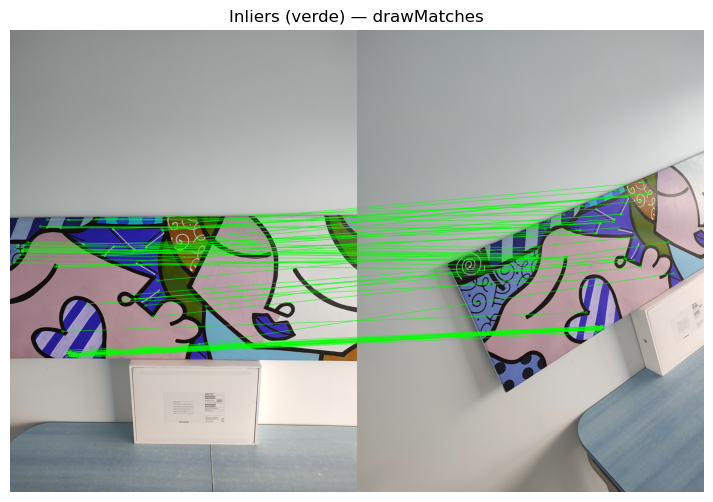

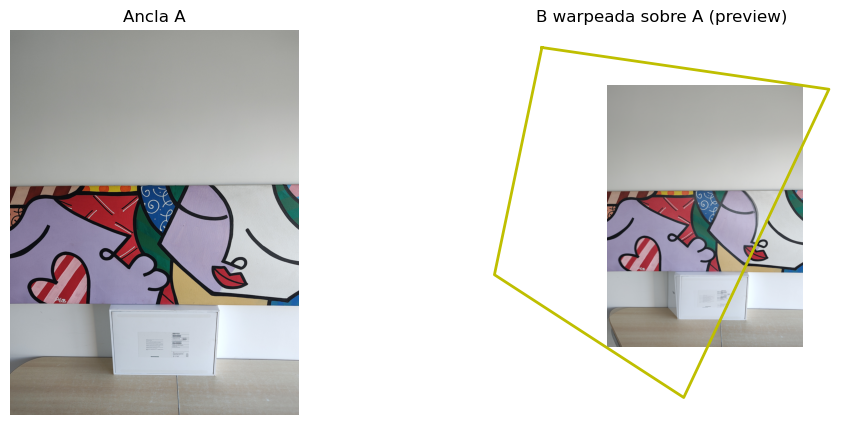

In [17]:
# === 3.5 — Validaciones visuales con tu estructura pano_data ===
import numpy as np, cv2, matplotlib.pyplot as plt

# ---- helpers coherentes con H: A <- B ----
def _proj(H, P):
    P1 = np.hstack([P, np.ones((P.shape[0], 1))])
    Q  = (H @ P1.T).T
    return Q[:, :2] / Q[:, 2:3]

def plot_inliers_side_by_side(imgA, imgB, ptsA, ptsB, inliers_mask, max_draw=300):
    """A | B con líneas verdes solo entre inliers (estilo consigna)."""
    A = imgA if imgA.ndim==3 else cv2.cvtColor(imgA, cv2.COLOR_GRAY2BGR)
    B = imgB if imgB.ndim==3 else cv2.cvtColor(imgB, cv2.COLOR_GRAY2BGR)
    hA,wA = A.shape[:2]; hB,wB = B.shape[:2]
    H = max(hA,hB)
    canvas = np.zeros((H, wA+wB, 3), dtype=A.dtype)
    canvas[:hA,:wA] = A; canvas[:hB,wA:wA+wB] = B

    idx = np.where(inliers_mask)[0]
    if len(idx) > max_draw:
        idx = np.linspace(0, len(idx)-1, max_draw).astype(int)
    for i in idx:
        xA,yA = int(round(ptsA[i,0])), int(round(ptsA[i,1]))
        xB,yB = int(round(ptsB[i,0])) + wA, int(round(ptsB[i,1]))
        cv2.circle(canvas, (xA,yA), 2, (0,255,0), -1)
        cv2.circle(canvas, (xB,yB), 2, (0,255,0), -1)
        cv2.line(canvas, (xA,yA), (xB,yB), (0,255,0), 1)

    plt.figure(figsize=(12,6))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title("Correspondencias inliers (RANSAC) — A | B")
    plt.axis('off'); plt.show()

def draw_matches_inliers_only(imgA, imgB, kpsA, kpsB, matches, inliers_mask, max_draw=300):
    """Alternativa con drawMatches filtrando solo inliers."""
    A = imgA if imgA.ndim==3 else cv2.cvtColor(imgA, cv2.COLOR_GRAY2BGR)
    B = imgB if imgB.ndim==3 else cv2.cvtColor(imgB, cv2.COLOR_GRAY2BGR)
    ms = []
    for m, keep in zip(matches, inliers_mask):
        if not keep: continue
        if hasattr(m, "queryIdx"):
            ms.append(m)
        else:
            ms.append(cv2.DMatch(_queryIdx=int(m[0]), _trainIdx=int(m[1]), _imgIdx=0, _distance=0))
    if len(ms) > max_draw:
        step = len(ms) / max_draw
        ms = [ms[int(i*step)] for i in range(max_draw)]
    out = cv2.drawMatches(A, kpsA, B, kpsB, ms, None,
                          matchColor=(0,255,0), singlePointColor=(255,0,0),
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12,6))
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.title("Inliers (verde) — drawMatches"); plt.axis('off'); plt.show()

def quick_overlay(imgA, imgB, H):
    """Preview rápido: B warpeada en el tamaño de A + polígono de esquinas transformadas."""
    Hh, Ww = imgA.shape[:2]
    warpB_on_A = cv2.warpPerspective(imgB, H, (Ww, Hh))
    alpha = 0.6
    overlay = imgA.copy()
    mask = (warpB_on_A.sum(axis=2) > 0) if (imgA.ndim==3) else (warpB_on_A>0)
    overlay[mask] = (alpha*warpB_on_A[mask] + (1-alpha)*overlay[mask]).astype(overlay.dtype)
    # esquinas de B transformadas
    hB,wB = imgB.shape[:2]
    CB = np.array([[0,0],[wB-1,0],[wB-1,hB-1],[0,hB-1]], np.float32).reshape(-1,1,2)
    CB_to_A = cv2.perspectiveTransform(CB, H).reshape(-1,2)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(imgA); plt.title("Ancla A"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(overlay); 
    plt.plot(list(CB_to_A[:,0])+[CB_to_A[0,0]], list(CB_to_A[:,1])+[CB_to_A[0,1]], 'y-', lw=2)
    plt.title("B warpeada sobre A (preview)"); plt.axis('off'); plt.show()

# ---- elegir el par a visualizar (0 o 1) ----
pairs = list(pano_data["matches"].keys())
par_idx = 0                         # cambiá a 1 para el otro par
par = pairs[par_idx]
m = pano_data["matches"][par]

iA, iB = m["iA"], m["iB"]
imgA = pano_data["imgs_rgb"][iA]    # ancla
imgB = pano_data["imgs_rgb"][iB]    # vecina
ptsA = np.asarray(m["ptsA"], float) # A
ptsB = np.asarray(m["ptsB"], float) # B

# ---- obtener H/inliers para este par: usa los ya calculados o los recalcula si hace falta ----
try:
    H_vis = H_ransac; inliers_vis = inliers_mask
    assert len(inliers_vis) == len(ptsA)
except Exception:
    # si no existen o no coinciden, recalculamos con tu RANSAC
    H_vis, inliers_vis = ransac_homography(ptsA, ptsB, thresh=3.5, max_trials=3000, confidence=0.995, random_state=42)

# ---- 2) A | B con líneas verdes uniendo SOLO inliers (estilo consigna) ----
# Dibujar solo 30 inliers aleatorios para que la figura sea más clara
idx = np.where(inliers_mask)[0]
sel = np.random.choice(idx, size=30, replace=False)
plot_inliers_side_by_side(imgA, imgB, ptsA[sel], ptsB[sel], np.ones(len(sel), bool))


# ---- 3) Alternativa drawMatches SOLO inliers (si querés la estética OpenCV) ----
draw_matches_inliers_only(imgA, imgB, m["kpsA"], m["kpsB"], m["matches"], inliers_vis)

# ---- 4) Overlay rápido de B→A + polígono de esquinas transformadas ----
quick_overlay(imgA, imgB, H_vis)


[3.6] Canvas óptimo -> ancho=1708, alto=1788, bbox(A∪H·B)=(-573, -198, 1135, 1590)
[3.6] Traslación T:
 [[  1.   0. 573.]
 [  0.   1. 198.]
 [  0.   0.   1.]]
[3.6] Homografía ajustada (T @ H):
 [[ 8.53169684e-01 -1.81792209e-01  2.42659393e+02]
 [ 1.36566728e-01  1.08087798e+00  6.33587852e-01]
 [-3.59233700e-04  1.81012575e-04  1.00000000e+00]]


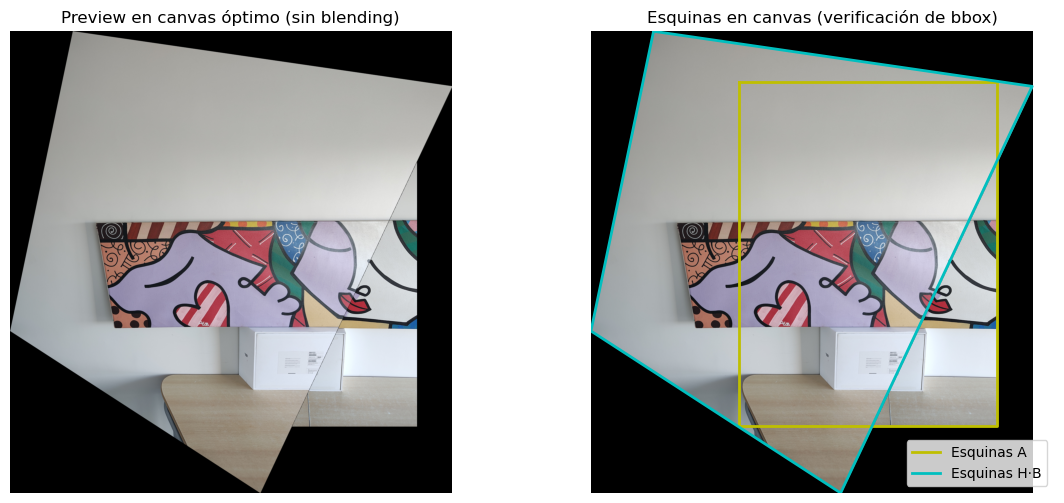

In [18]:
# === 3.6 — Canvas óptimo (bounding box + traslación) para A <- B ===
import numpy as np, cv2, matplotlib.pyplot as plt

# ---------- helpers coherentes con H: A <- B ----------
def _corners(img):
    h, w = img.shape[:2]
    return np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]], dtype=np.float32).reshape(-1,1,2)

def _bbox_from_points(P):
    """P: (N,1,2) float32 -> (xmin, ymin, xmax, ymax) como ints (floor/ceil)."""
    P2 = P.reshape(-1,2)
    xmin, ymin = np.floor(P2.min(axis=0))
    xmax, ymax = np.ceil (P2.max(axis=0))
    return int(xmin), int(ymin), int(xmax), int(ymax)

def _build_translation(tx, ty):
    return np.array([[1,0,tx],[0,1,ty],[0,0,1]], dtype=np.float64)

def compute_optimal_canvas(imgA, imgB, H_A_from_B):
    """
    Dado H: A <- B, calcula bounding box mínimo que contiene a:
      - las 4 esquinas de A en A (sin transformar)
      - las 4 esquinas de B transformadas con H
    Devuelve: T, (Wc,Hc), esquinas transformadas, bbox
    """
    CA = _corners(imgA)                    # esquinas de A en coords A
    CB = _corners(imgB)                    # esquinas de B
    CB_A = cv2.perspectiveTransform(CB, H_A_from_B)   # B -> A

    # juntar y sacar bbox
    allP = np.vstack([CA, CB_A])           # (8,1,2)
    xmin, ymin, xmax, ymax = _bbox_from_points(allP)
    # traslación para evitar coords negativas
    tx = -xmin if xmin < 0 else 0
    ty = -ymin if ymin < 0 else 0
    T = _build_translation(tx, ty)

    # tamaño final
    Wc = int(xmax + tx)
    Hc = int(ymax + ty)
    return T, (Wc, Hc), CA, CB_A, (xmin, ymin, xmax, ymax)

def place_A_on_canvas(imgA, T, size):
    """
    ubica A en el canvas usando solo la traslación T (warpPerspective con T).
    size = (Wc,Hc)
    """
    Wc, Hc = size
    return cv2.warpPerspective(imgA, T, (Wc, Hc))

def warp_B_to_canvas(imgB, H_A_from_B, T, size):
    """
    warpea B con H y luego aplica traslación T: canvas coords.
    """
    Wc, Hc = size
    H_adj = T @ H_A_from_B                 # primero H, luego T
    return cv2.warpPerspective(imgB, H_adj, (Wc, Hc)), H_adj

# ---------- elegir el par a mostrar (igual que venías usando) ----------
pairs = list(pano_data["matches"].keys())
par_idx = 0                  # cambiá a 1 para el otro par
par = pairs[par_idx]
m = pano_data["matches"][par]

iA, iB = m["iA"], m["iB"]
imgA = pano_data["imgs_rgb"][iA]   # ancla
imgB = pano_data["imgs_rgb"][iB]   # vecina

# Homografía del 3.5 (A <- B). Si no está en variables globales, recalculá con tu función.
try:
    H_A_from_B = H_ransac
except NameError:
    # Opcional: si no tenés H_ransac global, la calculamos para este par usando tus inliers
    ptsA = np.asarray(m["ptsA"], float)
    ptsB = np.asarray(m["ptsB"], float)
    H_A_from_B, inliers_mask_tmp = ransac_homography(ptsA, ptsB, thresh=3.5, max_trials=3000, confidence=0.995, random_state=42)

# ---------- cálculo de canvas óptimo ----------
T, (Wc, Hc), CA, CB_A, bbox = compute_optimal_canvas(imgA, imgB, H_A_from_B)

# warps al canvas: A traducida; B warpeada con H y traducida
canvasA = place_A_on_canvas(imgA, T, (Wc, Hc))
canvasB, H_adj = warp_B_to_canvas(imgB, H_A_from_B, T, (Wc, Hc))

print(f"[3.6] Canvas óptimo -> ancho={Wc}, alto={Hc}, bbox(A∪H·B)={bbox}")
print("[3.6] Traslación T:\n", T)
print("[3.6] Homografía ajustada (T @ H):\n", H_adj)

# ---------- previews (solo 3.6: sin blending todavía) ----------
# 1) A y B en el canvas óptimo (side-by-side overlay rápido con máscara binaria)
maskB = (canvasB.sum(axis=2) > 0)
preview = canvasA.copy()
preview[maskB] = canvasB[maskB]

# 2) dibujo de polígonos de esquinas para verificar bbox
CA_T = cv2.perspectiveTransform(CA, T).reshape(-1,2)     # esquinas de A en canvas
CB_T = cv2.perspectiveTransform(CB_A, T).reshape(-1,2)   # esquinas de B->A en canvas

def _plot_poly(ax, P, color, label):
    x = list(P[:,0]) + [P[0,0]]
    y = list(P[:,1]) + [P[0,1]]
    ax.plot(x, y, color, lw=2, label=label)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1); plt.imshow(preview); plt.title("Preview en canvas óptimo (sin blending)"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(preview); 
_plot_poly(plt.gca(), CA_T, 'y-', 'Esquinas A')
_plot_poly(plt.gca(), CB_T, 'c-', 'Esquinas H·B')
plt.legend(loc='lower right'); plt.title("Esquinas en canvas (verificación de bbox)"); plt.axis('off')
plt.show()

# Nota: este bloque cierra el 3.6 (canvas óptimo). En 3.7 haremos blending con máscaras (distanceTransform).


[3.7] Tamaño canvas: (1708, 1788) | Usando H_adj = T @ H


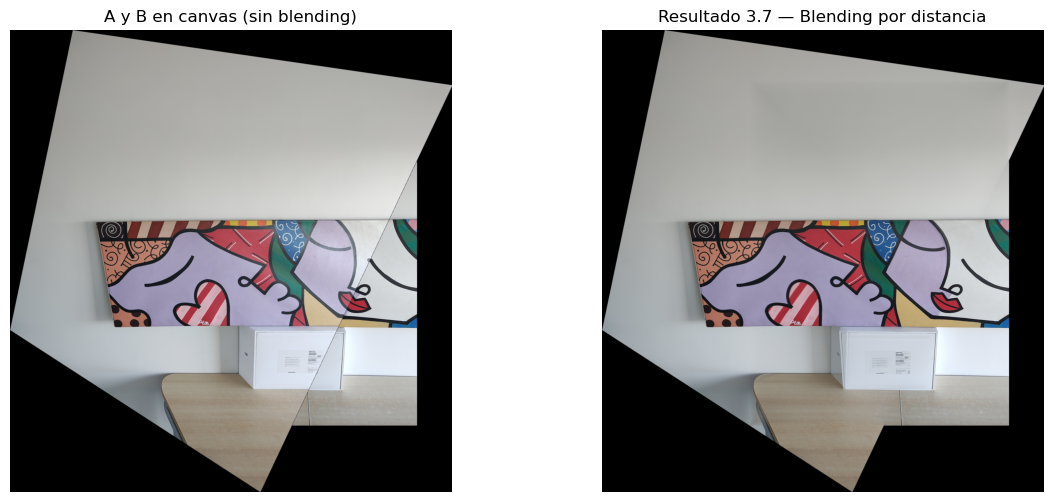

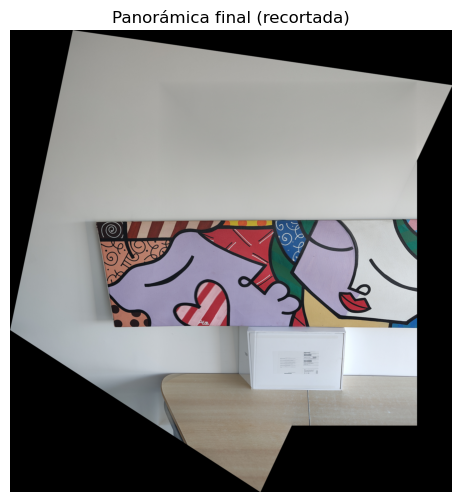

In [19]:
# === 3.7 — Stitching + Blending con distanceTransform (A <- B) ===
import numpy as np, cv2, matplotlib.pyplot as plt

# ------- helpers (compatibles con lo que armamos en 3.6) -------
def _corners(img):
    h, w = img.shape[:2]
    return np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]], dtype=np.float32).reshape(-1,1,2)

def _bbox_from_points(P):
    P2 = P.reshape(-1,2)
    xmin, ymin = np.floor(P2.min(axis=0))
    xmax, ymax = np.ceil (P2.max(axis=0))
    return int(xmin), int(ymin), int(xmax), int(ymax)

def _build_translation(tx, ty):
    return np.array([[1,0,tx],[0,1,ty],[0,0,1]], dtype=np.float64)

def compute_optimal_canvas(imgA, imgB, H_A_from_B):
    CA = _corners(imgA)
    CB = _corners(imgB)
    CB_A = cv2.perspectiveTransform(CB, H_A_from_B)   # B -> A
    allP = np.vstack([CA, CB_A])
    xmin, ymin, xmax, ymax = _bbox_from_points(allP)
    tx = -xmin if xmin < 0 else 0
    ty = -ymin if ymin < 0 else 0
    T = _build_translation(tx, ty)
    Wc, Hc = int(xmax + tx), int(ymax + ty)
    return T, (Wc, Hc)

def place_A_on_canvas(imgA, T, size):
    Wc, Hc = size
    return cv2.warpPerspective(imgA, T, (Wc, Hc))

def warp_B_to_canvas(imgB, H_A_from_B, T, size):
    Wc, Hc = size
    H_adj = T @ H_A_from_B
    return cv2.warpPerspective(imgB, H_adj, (Wc, Hc)), H_adj

def compute_weights(mask_uint8, blur_ksize=0, eps=1e-6):
    """
    mask_uint8: 0/1 (o 0/255). Devuelve pesos suavizados en [0,1].
    """
    m = (mask_uint8 > 0).astype(np.uint8)
    # distancia al borde (dentro de la región válida)
    dist = cv2.distanceTransform(m, cv2.DIST_L2, 5)
    if blur_ksize and blur_ksize > 1:
        dist = cv2.GaussianBlur(dist, (blur_ksize, blur_ksize), 0)
    # normalización independiente por imagen
    mx = float(dist.max())
    if mx < eps:
        return dist  # todo cero; devolver tal cual
    return (dist / (mx + eps)).astype(np.float32)

def weighted_blend(canvas_imgs):
    """
    canvas_imgs: lista de imágenes ya en el canvas (uint8, mismas dims).
    Hace blending canal a canal con pesos de distanceTransform.
    """
    Hc, Wc = canvas_imgs[0].shape[:2]
    acc_num = np.zeros((Hc, Wc, 3), dtype=np.float32)
    acc_den = np.zeros((Hc, Wc), dtype=np.float32)
    for img in canvas_imgs:
        # máscara binaria de validez
        if img.ndim == 2:
            m = (img > 0).astype(np.uint8)
        else:
            m = (img.sum(axis=2) > 0).astype(np.uint8)
        w = compute_weights(m, blur_ksize=0)  # podés probar blur_ksize=11 para transiciones más suaves
        acc_num += (img.astype(np.float32) * w[...,None])
        acc_den += w
    acc_den = np.clip(acc_den, 1e-6, None)
    out = (acc_num / acc_den[...,None])
    return np.clip(out, 0, 255).astype(np.uint8)

# ------- elegir el par (como antes) -------
pairs = list(pano_data["matches"].keys())
par_idx = 0
par = pairs[par_idx]
m = pano_data["matches"][par]
iA, iB = m["iA"], m["iB"]
imgA = pano_data["imgs_rgb"][iA]   # ancla
imgB = pano_data["imgs_rgb"][iB]   # vecina

# ------- obtener la H del 3.5 y el canvas del 3.6 (o recalcular si no están) -------
try:
    H_A_from_B  # H (A <- B) del 3.5
except NameError:
    ptsA = np.asarray(m["ptsA"], float)
    ptsB = np.asarray(m["ptsB"], float)
    H_A_from_B, _ = ransac_homography(ptsA, ptsB, thresh=3.5, max_trials=3000, confidence=0.995, random_state=42)

try:
    T, size  # del 3.6
except NameError:
    T, size = compute_optimal_canvas(imgA, imgB, H_A_from_B)

# ------- warps al canvas -------
canvasA = place_A_on_canvas(imgA, T, size)
canvasB, H_adj = warp_B_to_canvas(imgB, H_A_from_B, T, size)

print("[3.7] Tamaño canvas:", size, "| Usando H_adj = T @ H")
# ------- blending por distancia -------
pano = weighted_blend([canvasA, canvasB])

# ------- visualizaciones útiles -------
plt.figure(figsize=(14,6))
plt.subplot(1,2,1); plt.title("A y B en canvas (sin blending)")
no_blend = canvasA.copy()
maskB = (canvasB.sum(axis=2) > 0)
no_blend[maskB] = canvasB[maskB]
plt.imshow(no_blend); plt.axis('off')

plt.subplot(1,2,2); plt.title("Resultado 3.7 — Blending por distancia")
plt.imshow(pano); plt.axis('off')
plt.show()

# (Opcional) recorte automático del bounding box no vacío final
def auto_crop_nonzero(img):
    if img.ndim == 2:
        m = img > 0
    else:
        m = img.sum(axis=2) > 0
    ys, xs = np.where(m)
    if len(ys) == 0:
        return img
    y0, y1 = ys.min(), ys.max()+1
    x0, x1 = xs.min(), xs.max()+1
    return img[y0:y1, x0:x1]

pano_cropped = auto_crop_nonzero(pano)
plt.figure(figsize=(8,6))
plt.title("Panorámica final (recortada)") 
plt.imshow(pano_cropped); plt.axis('off')
plt.show()


Inliers AB: 72/165 | Inliers AC: 17/93


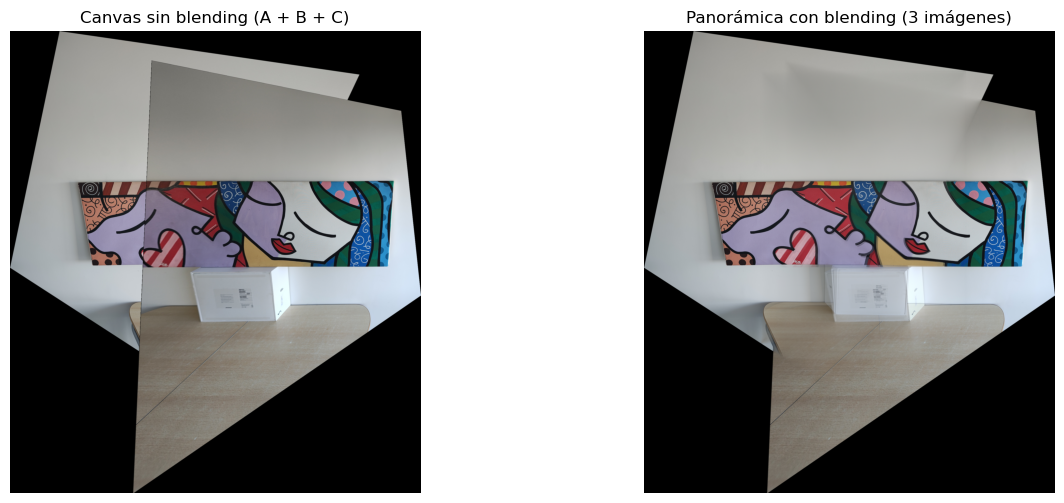

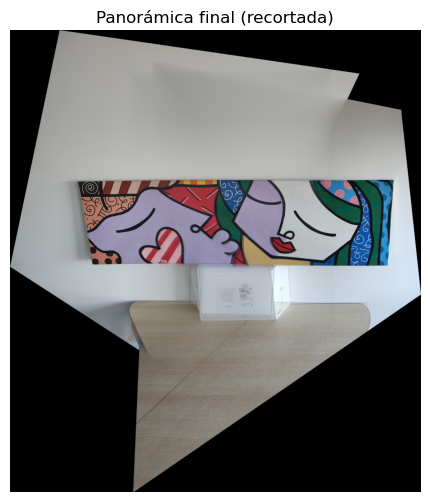

In [20]:
# === 3-imágenes: A (ancla) + B + C — Canvas óptimo + Blending por distancia ===
import numpy as np, cv2, matplotlib.pyplot as plt

# ------- helpers -------
def _corners(img):
    h, w = img.shape[:2]
    return np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]], dtype=np.float32).reshape(-1,1,2)

def _bbox_from_points(P):
    P2 = P.reshape(-1,2)
    xmin, ymin = np.floor(P2.min(axis=0))
    xmax, ymax = np.ceil (P2.max(axis=0))
    return int(xmin), int(ymin), int(xmax), int(ymax)

def _build_translation(tx, ty):
    return np.array([[1,0,tx],[0,1,ty],[0,0,1]], dtype=np.float64)

def compute_optimal_canvas_3(imgA, imgB, imgC, H_AB, H_AC):
    """Canvas mínimo que contiene A, H_AB·B, H_AC·C (todas en coords de A)."""
    CA  = _corners(imgA)
    CB  = _corners(imgB)
    CC  = _corners(imgC)
    CB_A = cv2.perspectiveTransform(CB, H_AB)
    CC_A = cv2.perspectiveTransform(CC, H_AC)
    allP = np.vstack([CA, CB_A, CC_A])
    xmin, ymin, xmax, ymax = _bbox_from_points(allP)
    tx = -xmin if xmin < 0 else 0
    ty = -ymin if ymin < 0 else 0
    T = _build_translation(tx, ty)
    Wc, Hc = int(xmax + tx), int(ymax + ty)
    return T, (Wc, Hc)

def place_on_canvas(img, H, size):
    """Warp con H (3x3). Si H = T (solo traslación) sirve para la ancla."""
    Wc, Hc = size
    return cv2.warpPerspective(img, H, (Wc, Hc))

def compute_weights(mask_uint8, blur_ksize=0, eps=1e-6):
    m = (mask_uint8 > 0).astype(np.uint8)
    dist = cv2.distanceTransform(m, cv2.DIST_L2, 5)
    if blur_ksize and blur_ksize > 1:
        dist = cv2.GaussianBlur(dist, (blur_ksize, blur_ksize), 0)
    mx = float(dist.max())
    if mx < eps: return dist
    return (dist / (mx + eps)).astype(np.float32)

def weighted_blend(canvas_imgs, blur_ksize=0):
    Hc, Wc = canvas_imgs[0].shape[:2]
    acc_num = np.zeros((Hc, Wc, 3), dtype=np.float32)
    acc_den = np.zeros((Hc, Wc), dtype=np.float32)
    for img in canvas_imgs:
        m = (img.sum(axis=2) > 0).astype(np.uint8)
        w = compute_weights(m, blur_ksize=blur_ksize)
        acc_num += img.astype(np.float32) * w[...,None]
        acc_den += w
    acc_den = np.clip(acc_den, 1e-6, None)
    out = acc_num / acc_den[...,None]
    return np.clip(out, 0, 255).astype(np.uint8)

def auto_crop_nonzero(img):
    m = (img.sum(axis=2) > 0)
    ys, xs = np.where(m)
    if len(ys)==0: return img
    y0, y1 = ys.min(), ys.max()+1
    x0, x1 = xs.min(), xs.max()+1
    return img[y0:y1, x0:x1]

# ------- detectar A como ancla y los dos pares (A,B) y (A,C) -------
pairs = list(pano_data["matches"].keys())

# Buscamos un índice de ancla que aparezca al menos en 2 pares como iA
anchor_idx = None
counts = {}
for p in pairs:
    iA = pano_data["matches"][p]["iA"]
    counts[iA] = counts.get(iA, 0) + 1
for k,v in counts.items():
    if v >= 2:
        anchor_idx = k; break
assert anchor_idx is not None, "No encontré dos pares con la misma ancla (iA). Revisá pano_data['matches']."

# Tomamos los dos pares de esa ancla
anchor_pairs = [p for p in pairs if pano_data["matches"][p]["iA"] == anchor_idx]
assert len(anchor_pairs) >= 2, "Necesito al menos dos pares con la misma ancla."

par_AB, par_AC = anchor_pairs[:2]
mAB = pano_data["matches"][par_AB]
mAC = pano_data["matches"][par_AC]

iA = mAB["iA"]; iB = mAB["iB"]; iC = mAC["iB"]
imgA = pano_data["imgs_rgb"][iA]
imgB = pano_data["imgs_rgb"][iB]
imgC = pano_data["imgs_rgb"][iC]

ptsA_B = np.asarray(mAB["ptsA"], float)
ptsB   = np.asarray(mAB["ptsB"], float)
ptsA_C = np.asarray(mAC["ptsA"], float)
ptsC   = np.asarray(mAC["ptsB"], float)

# ------- Homografías robustas hacia la ancla (A <- B) y (A <- C) -------
# Usamos tu RANSAC propio + refine final sin RANSAC (cv2.findHomography(..., method=0))
H_AB, inl_AB = ransac_homography(ptsA_B, ptsB, thresh=3.5, max_trials=3000, confidence=0.995, random_state=42)
H_AC, inl_AC = ransac_homography(ptsA_C, ptsC, thresh=3.5, max_trials=3000, confidence=0.995, random_state=43)

# Si preferís refinar con OpenCV (solo inliers, sin RANSAC) descomentá:
# H_AB, _ = cv2.findHomography(ptsB[inl_AB], ptsA_B[inl_AB], method=0)
# H_AC, _ = cv2.findHomography(ptsC[inl_AC], ptsA_C[inl_AC], method=0)

print(f"Inliers AB: {int(inl_AB.sum())}/{len(inl_AB)} | Inliers AC: {int(inl_AC.sum())}/{len(inl_AC)}")

# ------- Canvas óptimo global (A, H_AB·B, H_AC·C) -------
T, size = compute_optimal_canvas_3(imgA, imgB, imgC, H_AB, H_AC)

# Homografías ajustadas al canvas (primero H_i, luego T)
H_A   = T                          # para la ancla solo traslación
H_Bad = T @ H_AB
H_Cad = T @ H_AC

# ------- Warps al canvas -------
canA = place_on_canvas(imgA, H_A,   size)
canB = place_on_canvas(imgB, H_Bad, size)
canC = place_on_canvas(imgC, H_Cad, size)

# ------- Blending (ajustá blur_ksize para suavizar costuras) -------
pano_no_blend = canA.copy()
mB = (canB.sum(axis=2) > 0); pano_no_blend[mB] = canB[mB]
mC = (canC.sum(axis=2) > 0); pano_no_blend[mC] = canC[mC]

pano_blend = weighted_blend([canA, canB, canC], blur_ksize=11)
pano_final = auto_crop_nonzero(pano_blend)

# ------- Visualizaciones -------
plt.figure(figsize=(15,6))
plt.subplot(1,2,1); plt.title("Canvas sin blending (A + B + C)")
plt.imshow(pano_no_blend); plt.axis('off')
plt.subplot(1,2,2); plt.title("Panorámica con blending (3 imágenes)")
plt.imshow(pano_blend); plt.axis('off')
plt.show()

plt.figure(figsize=(8,6))
plt.title("Panorámica final (recortada)")
plt.imshow(pano_final); plt.axis('off')
plt.show()

# (Opcional) Guardar en pano_data para reutilizar:
pano_data["H_A_from_B"] = H_AB
pano_data["H_A_from_C"] = H_AC
pano_data["T_canvas"]   = T
pano_data["size_canvas"]= size
pano_data["pano3"]      = pano_final
